In [20]:
# required libraries
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [21]:
# setting root folder
DATA_ROOT = "dataset"

# common settings
IMG_SIZE = (32, 32)
BATCH_SIZE = 128
SEED = 1

# train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_ROOT, "train"),
    labels="inferred",
    label_mode="binary",
    class_names=["FAKE", "REAL"],  # ensure FAKE=0, REAL=1 (matches paper)
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

# test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_ROOT, "test"),
    labels="inferred",
    label_mode="binary",
    class_names=["FAKE", "REAL"],  # same ordering as train
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,                # keep test set order fixed
)

# normalization
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# data sanity check
for images, labels in train_ds.take(1):
    print("Train batch images:", images.shape)
    print("Train batch labels:", labels.shape)


Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Train batch images: (128, 32, 32, 3)
Train batch labels: (128, 1)


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

# getting number of batches in the training dataset
train_cardinality = tf.data.experimental.cardinality(train_ds).numpy()
val_ratio = 0.1
val_batches = int(train_cardinality * val_ratio)
print("Total train batches:", train_cardinality)

# creating validation and (reduced) training datasets
val_ds = train_ds.take(val_batches)
train_ds = train_ds.skip(val_batches)

print("Train batches after split:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())

# adding cache + prefetching for performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Total train batches: 782
Train batches after split: 704
Val batches: 78


In [23]:
# Model architecture
# - 2 convolutional layers with 32 filters each (feature extractor)
# - 1 dense hidden layer with 64 units
# - 1 sigmoid output neuron for REAL (1) vs FAKE (0)

def build_cifake_cnn(input_shape=(32, 32, 3)):
    inputs = tf.keras.Input(shape=input_shape, name="input_image")

    # Conv block 1: 32 filters
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        name="conv1",
    )(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool1")(x)

    # Conv block 2: 32 filters
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        name="conv2",
    )(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool2")(x)

    # Flatten + Dense(64) head
    x = tf.keras.layers.Flatten(name="flatten")(x)
    x = tf.keras.layers.Dense(64, activation="relu", name="dense_64")(x)

    # Binary output: REAL (1) vs FAKE (0)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cifake_cnn")
    return model


model = build_cifake_cnn()
model.summary()

Model: "cifake_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_64 (Dense)            (None, 64)                1

In [24]:
# configuring model
EPOCHS = 30
PATIENCE = 3

# compiling model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",              # paper: binary cross-entropy
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

# training model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True,
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/30
704/704 [==============================] - 20s 27ms/step - loss: 0.3501 - accuracy: 0.8432 - precision: 0.8372 - recall: 0.8526 - val_loss: 0.2564 - val_accuracy: 0.8940 - val_precision: 0.8604 - val_recall: 0.9381
Epoch 2/30
704/704 [==============================] - 16s 23ms/step - loss: 0.2267 - accuracy: 0.9081 - precision: 0.9039 - recall: 0.9136 - val_loss: 0.2026 - val_accuracy: 0.9176 - val_precision: 0.8976 - val_recall: 0.9407
Epoch 3/30
704/704 [==============================] - 17s 25ms/step - loss: 0.1889 - accuracy: 0.9252 - precision: 0.9223 - recall: 0.9288 - val_loss: 0.1975 - val_accuracy: 0.9188 - val_precision: 0.8979 - val_recall: 0.9431
Epoch 4/30
704/704 [==============================] - 16s 23ms/step - loss: 0.1726 - accuracy: 0.9316 - precision: 0.9295 - recall: 0.9343 - val_loss: 0.1819 - val_accuracy: 0.9271 - val_precision: 0.9207 - val_recall: 0.9330
Epoch 5/30
704/704 [==============================] - 20s 28ms/step - loss: 0.1586 - accuracy: 0

In [25]:
# evaluating model
test_results = model.evaluate(test_ds, verbose=0)

# test set results
# for name, value in zip(model.metrics_names, test_results):
#     print(f"{name}: {value:.4f}")

# computing F1 score
y_true = np.concatenate([y.numpy().ravel() for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob >= 0.5).astype("int32")

# displaying precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 score:          {f1:.4f}")


157/157 [==============================] - 1s 7ms/step
Precision: 0.9339
Recall:    0.9450
F1 score:          0.9394


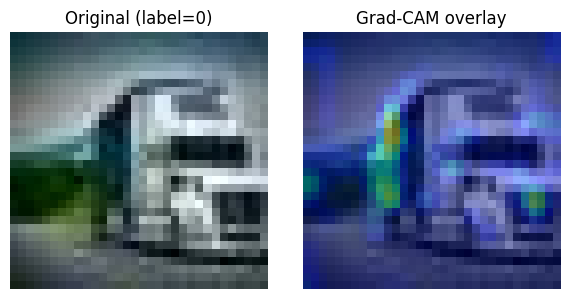

True label (0=FAKE, 1=REAL): 0
Heatmap shape: (32, 32)


/var/folders/6d/6rs61bc54r94r2hj35rhqd4r0000gn/T/ipykernel_20604/715765847.py:105: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("True label (0=FAKE, 1=REAL):", int(label))


In [26]:
# Grad-CAM heatmap functions
def make_gradcam_heatmap(img_batch, model, last_conv_layer_name="conv2"):
    """
    img_batch: a 4D tensor (1, 32, 32, 3), already normalized like training data.
    model: trained Keras model.
    last_conv_layer_name: name of the last Conv2D layer (here "conv2").
    Returns: 2D heatmap (32, 32) with values in [0, 1].
    """

    # Build a model that maps input -> (last conv layer output, model output)
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output],
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_batch)
        # For binary classification, we consider the logit for class "REAL" (1)
        # Since output is sigmoid, predictions[:, 0] is p(REAL)
        class_channel = predictions[:, 0]

    # Gradient of the class score w.r.t. feature maps
    grads = tape.gradient(class_channel, conv_outputs)[0]       # (H, W, C)
    conv_outputs = conv_outputs[0]                              # (H, W, C)

    # Global average pooling of gradients over H, W -> importance weights α_k
    weights = tf.reduce_mean(grads, axis=(0, 1))                # (C,)

    # Weighted sum over channels
    cam = tf.zeros(conv_outputs.shape[:2], dtype=tf.float32)    # (H, W)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    # ReLU to keep only positive contributions (as per Grad-CAM definition)
    cam = tf.nn.relu(cam)

    # Normalize to [0, 1]
    cam_max = tf.reduce_max(cam)
    cam = cam / (cam_max + 1e-8)

    # Resize to input size (32x32)
    cam = tf.image.resize(cam[..., tf.newaxis], (32, 32))[..., 0]

    return cam.numpy()

def overlay_heatmap_on_image(image, heatmap, alpha=0.4):
    """
    image: (32, 32, 3) float32 in [0,1]
    heatmap: (32, 32) float32 in [0,1]
    alpha: blending factor for heatmap
    returns: RGB image with heatmap overlay, uint8 [0,255]
    """
    # Ensure image is in [0,1]
    if image.max() > 1.0:
        image = image / 255.0

    # Use 'jet' colormap
    cmap = plt.get_cmap("jet")
    heatmap_color = cmap(heatmap)[:, :, :3]  # drop alpha channel

    # Blend heatmap with original image
    overlay = heatmap_color * alpha + image * (1.0 - alpha)
    overlay = np.clip(overlay, 0.0, 1.0)
    overlay = (overlay * 255).astype("uint8")
    return overlay


def show_gradcam_example(image, label, model, last_conv_layer_name="conv2"):
    """
    image: (32, 32, 3) single image tensor/array
    label: scalar 0/1
    """
    # Ensure batch dimension
    img_batch = image[None, ...]
    heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name)

    overlay = overlay_heatmap_on_image(image.numpy() if hasattr(image, "numpy") else image,
                                       heatmap)

    plt.figure(figsize=(6, 3))

    # Original
    plt.subplot(1, 2, 1)
    plt.title(f"Original (label={int(label)})")
    plt.axis("off")
    plt.imshow(image)

    # Overlay
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM overlay")
    plt.axis("off")
    plt.imshow(overlay)

    plt.tight_layout()
    plt.show()

# generating Grad-CAM for one test image

for imgs, labels in test_ds.take(1):
    show_gradcam_example(imgs[0], labels[0], model, last_conv_layer_name="conv2")
    break

heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name="conv2")
print("True label (0=FAKE, 1=REAL):", int(label))
print("Heatmap shape:", heatmap.shape)


In [27]:
OUTPUT = "gradcam_test"

# subfolders for REAL (1) and FAKE (0)
os.makedirs(os.path.join(OUTPUT, "REAL"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT, "FAKE"), exist_ok=True)

def save_gradcam_overlays(dataset,
                          model,
                          last_conv_layer_name="conv2",
                          output=OUTPUT,
                          max_images=None):
    """
    dataset: tf.data.Dataset (e.g., test_ds)
    model: trained model
    last_conv_layer_name: last conv layer used for Grad-CAM
    output: root directory for saving images
    max_images: stop after saving this many images (None -> all)
    """
    saved = 0

    for batch_idx, (imgs, labels) in enumerate(dataset):
        batch_size = imgs.shape[0]

        for i in range(batch_size):
            img = imgs[i]          # (32, 32, 3), already normalized [0,1]
            label = int(labels[i].numpy())  # 0=FAKE, 1=REAL

            # Prepare batch of size 1 for Grad-CAM
            img_batch = img[None, ...]
            heatmap = make_gradcam_heatmap(
                img_batch, model, last_conv_layer_name
            )

            # Overlay heatmap on original image
            overlay = overlay_heatmap_on_image(img.numpy(), heatmap)  # uint8

            # Choose class folder
            cls_name = "REAL" if label == 1 else "FAKE"
            cls_dir = os.path.join(OUTPUT, cls_name)

            # Construct filename: e.g. REAL_batch0003_img0017.png
            filename = f"{cls_name}_b{batch_idx:04d}_i{i:04d}.png"
            filepath = os.path.join(cls_dir, filename)

            # Save overlay using PIL
            Image.fromarray(overlay).save(filepath)

            saved += 1
            if (max_images is not None) and (saved >= max_images):
                print(f"Reached max_images={max_images}, stopping.")
                return

    print(f"Saved {saved} Grad-CAM overlays to '{OUTPUT}'.")


# Run on ALL test images (set max_images to a number if you want a subset)
save_gradcam_overlays(
    test_ds,
    model,
    last_conv_layer_name="conv2",
    output=OUTPUT,
    max_images=None,    # e.g. 500 if you just want first 500
)

/var/folders/6d/6rs61bc54r94r2hj35rhqd4r0000gn/T/ipykernel_20604/4047923763.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # 0=FAKE, 1=REAL


Saved 20000 Grad-CAM overlays to 'gradcam_test'.
